Drive mount

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


global variable init

In [2]:
pwd_folder = '/content/drive/MyDrive/Colab_Notebooks/CVAE/'

Import package

In [3]:
import cv2, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

from drive.MyDrive.Colab_Notebooks.CVAE.model import Conditional_Auto_Encoder
from drive.MyDrive.Colab_Notebooks.CVAE.utils import ELBO_loss

MINST data download



In [4]:
train_dataset = datasets.MNIST(root = pwd_folder + "MNIST_data/train",
                               train = True,
                               download = True,
                               transform = transforms.ToTensor( ))

test_dataset = datasets.MNIST(root = pwd_folder + "MNIST_data/test",
                              train = False,
                              download = True,
                              transform = transforms.ToTensor( ))

100%|██████████| 9912422/9912422 [00:00<00:00, 172216055.46it/s]


Extracting /content/drive/MyDrive/Colab_Notebooks/CVAE/MNIST_data/train/MNIST/raw/train-images-idx3-ubyte.gz to /content/drive/MyDrive/Colab_Notebooks/CVAE/MNIST_data/train/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 12622245.89it/s]


Extracting /content/drive/MyDrive/Colab_Notebooks/CVAE/MNIST_data/train/MNIST/raw/train-labels-idx1-ubyte.gz to /content/drive/MyDrive/Colab_Notebooks/CVAE/MNIST_data/train/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 78443484.83it/s]


Extracting /content/drive/MyDrive/Colab_Notebooks/CVAE/MNIST_data/train/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/drive/MyDrive/Colab_Notebooks/CVAE/MNIST_data/train/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22924824.03it/s]

Extracting /content/drive/MyDrive/Colab_Notebooks/CVAE/MNIST_data/train/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/drive/MyDrive/Colab_Notebooks/CVAE/MNIST_data/train/MNIST/raw



100%|██████████| 9912422/9912422 [00:00<00:00, 70397625.48it/s]


Extracting /content/drive/MyDrive/Colab_Notebooks/CVAE/MNIST_data/test/MNIST/raw/train-images-idx3-ubyte.gz to /content/drive/MyDrive/Colab_Notebooks/CVAE/MNIST_data/test/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 5227675.38it/s]


Extracting /content/drive/MyDrive/Colab_Notebooks/CVAE/MNIST_data/test/MNIST/raw/train-labels-idx1-ubyte.gz to /content/drive/MyDrive/Colab_Notebooks/CVAE/MNIST_data/test/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 69477119.17it/s]


Extracting /content/drive/MyDrive/Colab_Notebooks/CVAE/MNIST_data/test/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/drive/MyDrive/Colab_Notebooks/CVAE/MNIST_data/test/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 27022026.62it/s]

Extracting /content/drive/MyDrive/Colab_Notebooks/CVAE/MNIST_data/test/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/drive/MyDrive/Colab_Notebooks/CVAE/MNIST_data/test/MNIST/raw



Data Loader

In [5]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False)

Set hyper parameter(Conditional Vairational Auto Encoder)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cvae_model = Conditional_Auto_Encoder(device = device).to(device)
epoches = 30
lr = 1e-3
optimizer = optim.Adam(cvae_model.parameters(), lr=lr)
Criterion = ELBO_loss

In [ ]:
for epoch_i in range(epoches):
  '''----------------Train----------------'''
  cvae_model.train()

  train_loss = 0.

  for x, y in tqdm(train_loader, desc = 'Epoch {}/{}'.format(epoch_i+1, epoches)):
    x  = x.view(x.size()[0], -1)
    batch = y.size()[0]
    y_one_hot = torch.zeros(batch, 10)
    y_one_hot[torch.arange(batch),y] = 1

    optimizer.zero_grad()

    x = x.to(device)
    y_one_hot = y_one_hot.to(device)

    x_reconst, (mean, stddev), _ = cvae_model(x, y_one_hot)
    loss, _ = Criterion(x_reconst, x, mean, stddev)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
  train_loss /= len(train_loader)

  '''----------------Test----------------'''

  cvae_model.eval()
  test_loss = 0.
  test_reconst_err = 0.
  test_KL_err = 0.

  with torch.no_grad():
    for x, y in test_loader:
      x  = x.view(x.size()[0], -1)
      batch = y.size()[0]
      y_one_hot = torch.zeros(batch, 10)
      y_one_hot[torch.arange(batch),y] = 1

      x = x.to(device)
      y_one_hot = y_one_hot.to(device)

      x_reconst, (mean, stddev), _ = cvae_model(x, y_one_hot)
      loss, (reconst_err, KL_err) = Criterion(x_reconst, x, mean, stddev)
      test_loss += loss.item()

      test_reconst_err += reconst_err.item()
      test_KL_err      += KL_err.item()


  test_loss /= len(test_loader)

  test_reconst_err /= len(test_loader)
  test_KL_err      /= len(test_loader)

  print('Train loss = {:.4f}   Test loss = {:.4f}'.format(train_loss, test_loss))
  print('Test reconst_err, KL_err {:.4f}, {:.4f}'.format(test_reconst_err, test_KL_err))

Epoch 1/30: 100%|██████████| 469/469 [00:14<00:00, 31.68it/s]


Train loss = 180.6254   Test loss = 151.9260
Test reconst_err, KL_err 148.6460, 3.2801


Epoch 2/30: 100%|██████████| 469/469 [00:08<00:00, 52.70it/s]


Train loss = 156.3825   Test loss = 145.8671
Test reconst_err, KL_err 142.2350, 3.6321


Epoch 3/30: 100%|██████████| 469/469 [00:07<00:00, 59.64it/s]


Train loss = 152.9639   Test loss = 143.6025
Test reconst_err, KL_err 139.9456, 3.6569


Epoch 4/30: 100%|██████████| 469/469 [00:08<00:00, 56.13it/s]


Train loss = 151.2928   Test loss = 142.3711
Test reconst_err, KL_err 138.5335, 3.8376


Epoch 5/30: 100%|██████████| 469/469 [00:08<00:00, 52.86it/s]


Train loss = 150.2673   Test loss = 141.1564
Test reconst_err, KL_err 137.6628, 3.4936


Epoch 6/30: 100%|██████████| 469/469 [00:08<00:00, 54.82it/s]


Train loss = 149.6475   Test loss = 141.3988
Test reconst_err, KL_err 137.7853, 3.6135


Epoch 7/30: 100%|██████████| 469/469 [00:07<00:00, 59.30it/s]


Train loss = 149.0927   Test loss = 140.6549
Test reconst_err, KL_err 136.8441, 3.8107


Epoch 8/30: 100%|██████████| 469/469 [00:08<00:00, 53.17it/s]


Train loss = 148.6354   Test loss = 139.8989
Test reconst_err, KL_err 136.1972, 3.7017


Epoch 9/30: 100%|██████████| 469/469 [00:09<00:00, 48.93it/s]


Train loss = 148.3062   Test loss = 139.6776
Test reconst_err, KL_err 136.0305, 3.6471


Epoch 10/30: 100%|██████████| 469/469 [00:08<00:00, 57.19it/s]


Train loss = 147.8884   Test loss = 139.1971
Test reconst_err, KL_err 135.6476, 3.5494


Epoch 11/30: 100%|██████████| 469/469 [00:08<00:00, 58.11it/s]


Train loss = 147.5920   Test loss = 138.8165
Test reconst_err, KL_err 135.3458, 3.4707


Epoch 12/30: 100%|██████████| 469/469 [00:08<00:00, 52.75it/s]


Train loss = 147.3441   Test loss = 138.8426
Test reconst_err, KL_err 135.3238, 3.5188


Epoch 13/30: 100%|██████████| 469/469 [00:08<00:00, 52.73it/s]


Train loss = 147.1048   Test loss = 138.3877
Test reconst_err, KL_err 134.8906, 3.4971


Epoch 14/30: 100%|██████████| 469/469 [00:07<00:00, 59.96it/s]


Train loss = 146.8621   Test loss = 138.3777
Test reconst_err, KL_err 134.9224, 3.4552


Epoch 15/30: 100%|██████████| 469/469 [00:08<00:00, 53.67it/s]


Train loss = 146.7609   Test loss = 138.1097
Test reconst_err, KL_err 134.6899, 3.4197


Epoch 16/30: 100%|██████████| 469/469 [00:08<00:00, 52.80it/s]


Train loss = 146.5993   Test loss = 137.6227
Test reconst_err, KL_err 134.2303, 3.3924


Epoch 17/30: 100%|██████████| 469/469 [00:08<00:00, 55.28it/s]


Train loss = 146.3783   Test loss = 138.0632
Test reconst_err, KL_err 134.7100, 3.3532


Epoch 18/30: 100%|██████████| 469/469 [00:08<00:00, 58.38it/s]


Train loss = 146.2826   Test loss = 137.8960
Test reconst_err, KL_err 134.5670, 3.3290


Epoch 19/30: 100%|██████████| 469/469 [00:09<00:00, 51.84it/s]


Train loss = 146.2528   Test loss = 137.8798
Test reconst_err, KL_err 134.3518, 3.5280


Epoch 20/30: 100%|██████████| 469/469 [00:09<00:00, 51.86it/s]


Train loss = 146.1161   Test loss = 137.9946
Test reconst_err, KL_err 134.4999, 3.4948


Epoch 21/30: 100%|██████████| 469/469 [00:07<00:00, 59.77it/s]


Train loss = 146.1410   Test loss = 137.4635
Test reconst_err, KL_err 134.0862, 3.3772


Epoch 22/30: 100%|██████████| 469/469 [00:08<00:00, 55.81it/s]


Train loss = 145.9572   Test loss = 137.7824
Test reconst_err, KL_err 134.4441, 3.3383


Epoch 23/30: 100%|██████████| 469/469 [00:08<00:00, 52.89it/s]


Train loss = 145.8804   Test loss = 137.2168
Test reconst_err, KL_err 133.7293, 3.4875


Epoch 24/30: 100%|██████████| 469/469 [00:08<00:00, 54.04it/s]


Train loss = 145.8173   Test loss = 137.3429
Test reconst_err, KL_err 133.9092, 3.4338


Epoch 25/30: 100%|██████████| 469/469 [00:07<00:00, 60.29it/s]


Train loss = 145.7187   Test loss = 137.2679
Test reconst_err, KL_err 133.9525, 3.3155


Epoch 26/30: 100%|██████████| 469/469 [00:10<00:00, 46.38it/s]


Train loss = 145.6992   Test loss = 137.3545
Test reconst_err, KL_err 134.1268, 3.2277


Epoch 27/30: 100%|██████████| 469/469 [00:09<00:00, 48.49it/s]


Train loss = 145.5556   Test loss = 137.2753
Test reconst_err, KL_err 133.9564, 3.3189


Epoch 28/30: 100%|██████████| 469/469 [00:09<00:00, 50.88it/s]


Train loss = 145.5914   Test loss = 137.3258
Test reconst_err, KL_err 133.8029, 3.5229


Epoch 29/30: 100%|██████████| 469/469 [00:07<00:00, 60.33it/s]


Train loss = 145.4488   Test loss = 136.8137
Test reconst_err, KL_err 133.3669, 3.4467


Epoch 30/30: 100%|██████████| 469/469 [00:11<00:00, 39.44it/s]


Train loss = 145.5452   Test loss = 136.9711
Test reconst_err, KL_err 133.6313, 3.3398


Save Model

In [ ]:
# torch.save(cvae_model.state_dict(), pwd_folder + 'weights/CVAE_weight_epoch_30.pt')

Load Model

In [8]:
load_cvae_model = Conditional_Auto_Encoder(device = device)
load_cvae_model.load_state_dict(torch.load(pwd_folder + 'weights/CVAE_weight_epoch_30.pt'))
load_cvae_model = load_cvae_model.to(device)

class 별 Latent vector 확인(학습된 mean, stddev 에서 Sampling)

In [9]:
cvae_z_dict = defaultdict(int)
reconst_dict = defaultdict(int)

for class_i in range(10):
  idx = test_dataset.targets == class_i
  datset_class_i = test_dataset.data[idx][:800]

  load_cvae_model.eval()
  with torch.no_grad():
    x = datset_class_i.view(datset_class_i.size()[0], -1)
    x = x.type(torch.FloatTensor)

    y = torch.zeros(datset_class_i.size()[0], dtype=torch.long) + class_i
    y_one_hot = torch.zeros(datset_class_i.size()[0], 10)
    y_one_hot[torch.arange(datset_class_i.size()[0]),y] = 1

    x = x.to(device)
    y_one_hot = y_one_hot.to(device)

    reconst_x, (_, _), z_cvae = load_cvae_model(x, y_one_hot)

    z_cvae = z_cvae.detach().to('cpu')
    cvae_z_dict['z_class_{}'.format(class_i)] = z_cvae

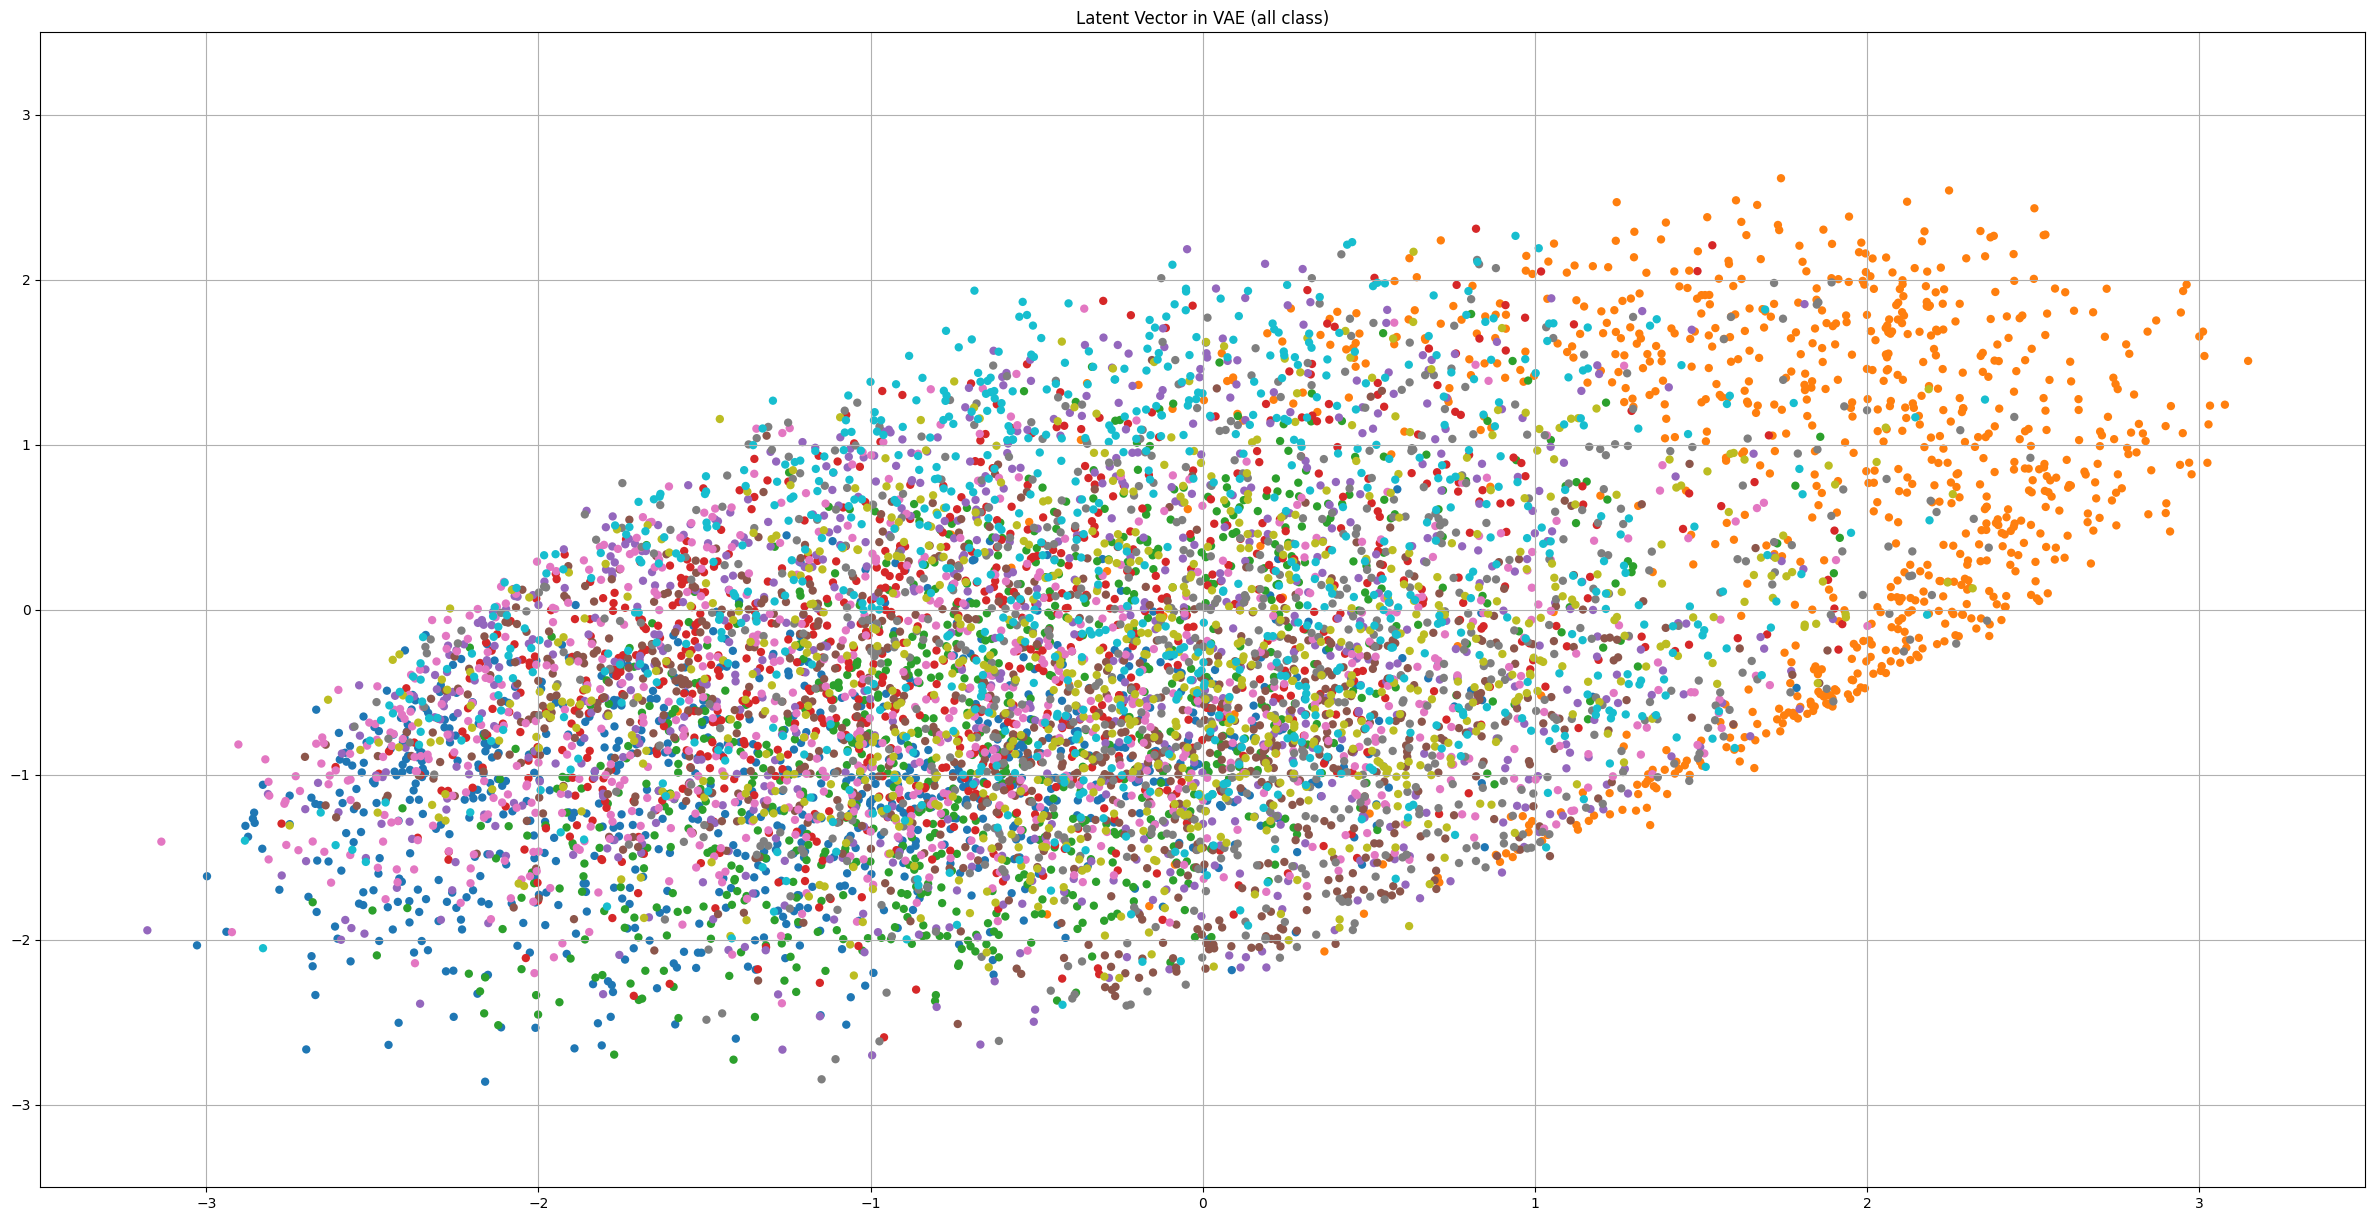

In [91]:
import matplotlib.colors as mcolors

color_list = mcolors.TABLEAU_COLORS

fig, ax = plt.subplots(1,1, figsize=(30, 15))
x, y, color = [], [], []

for class_i, z in enumerate(cvae_z_dict.values()):
  x.append(z[:,0].tolist())
  y.append(z[:,1].tolist())
  color += [list(color_list.keys())[class_i]]*z.size()[0]

x, y, color = np.array(x), np.array(y), np.array(color)
x = x.reshape(-1)
y = y.reshape(-1)
color = color.reshape(-1)
ax.set_title('Latent Vector in VAE (all class)')
ax.scatter(x, y, c=color, marker='o', edgecolor='none')
ax.set_xlim([-3.5, 3.5])
ax.set_ylim([-3.5, 3.5])
plt.grid(True)

fig.savefig(pwd_folder + 'result/figure_all_index.png')

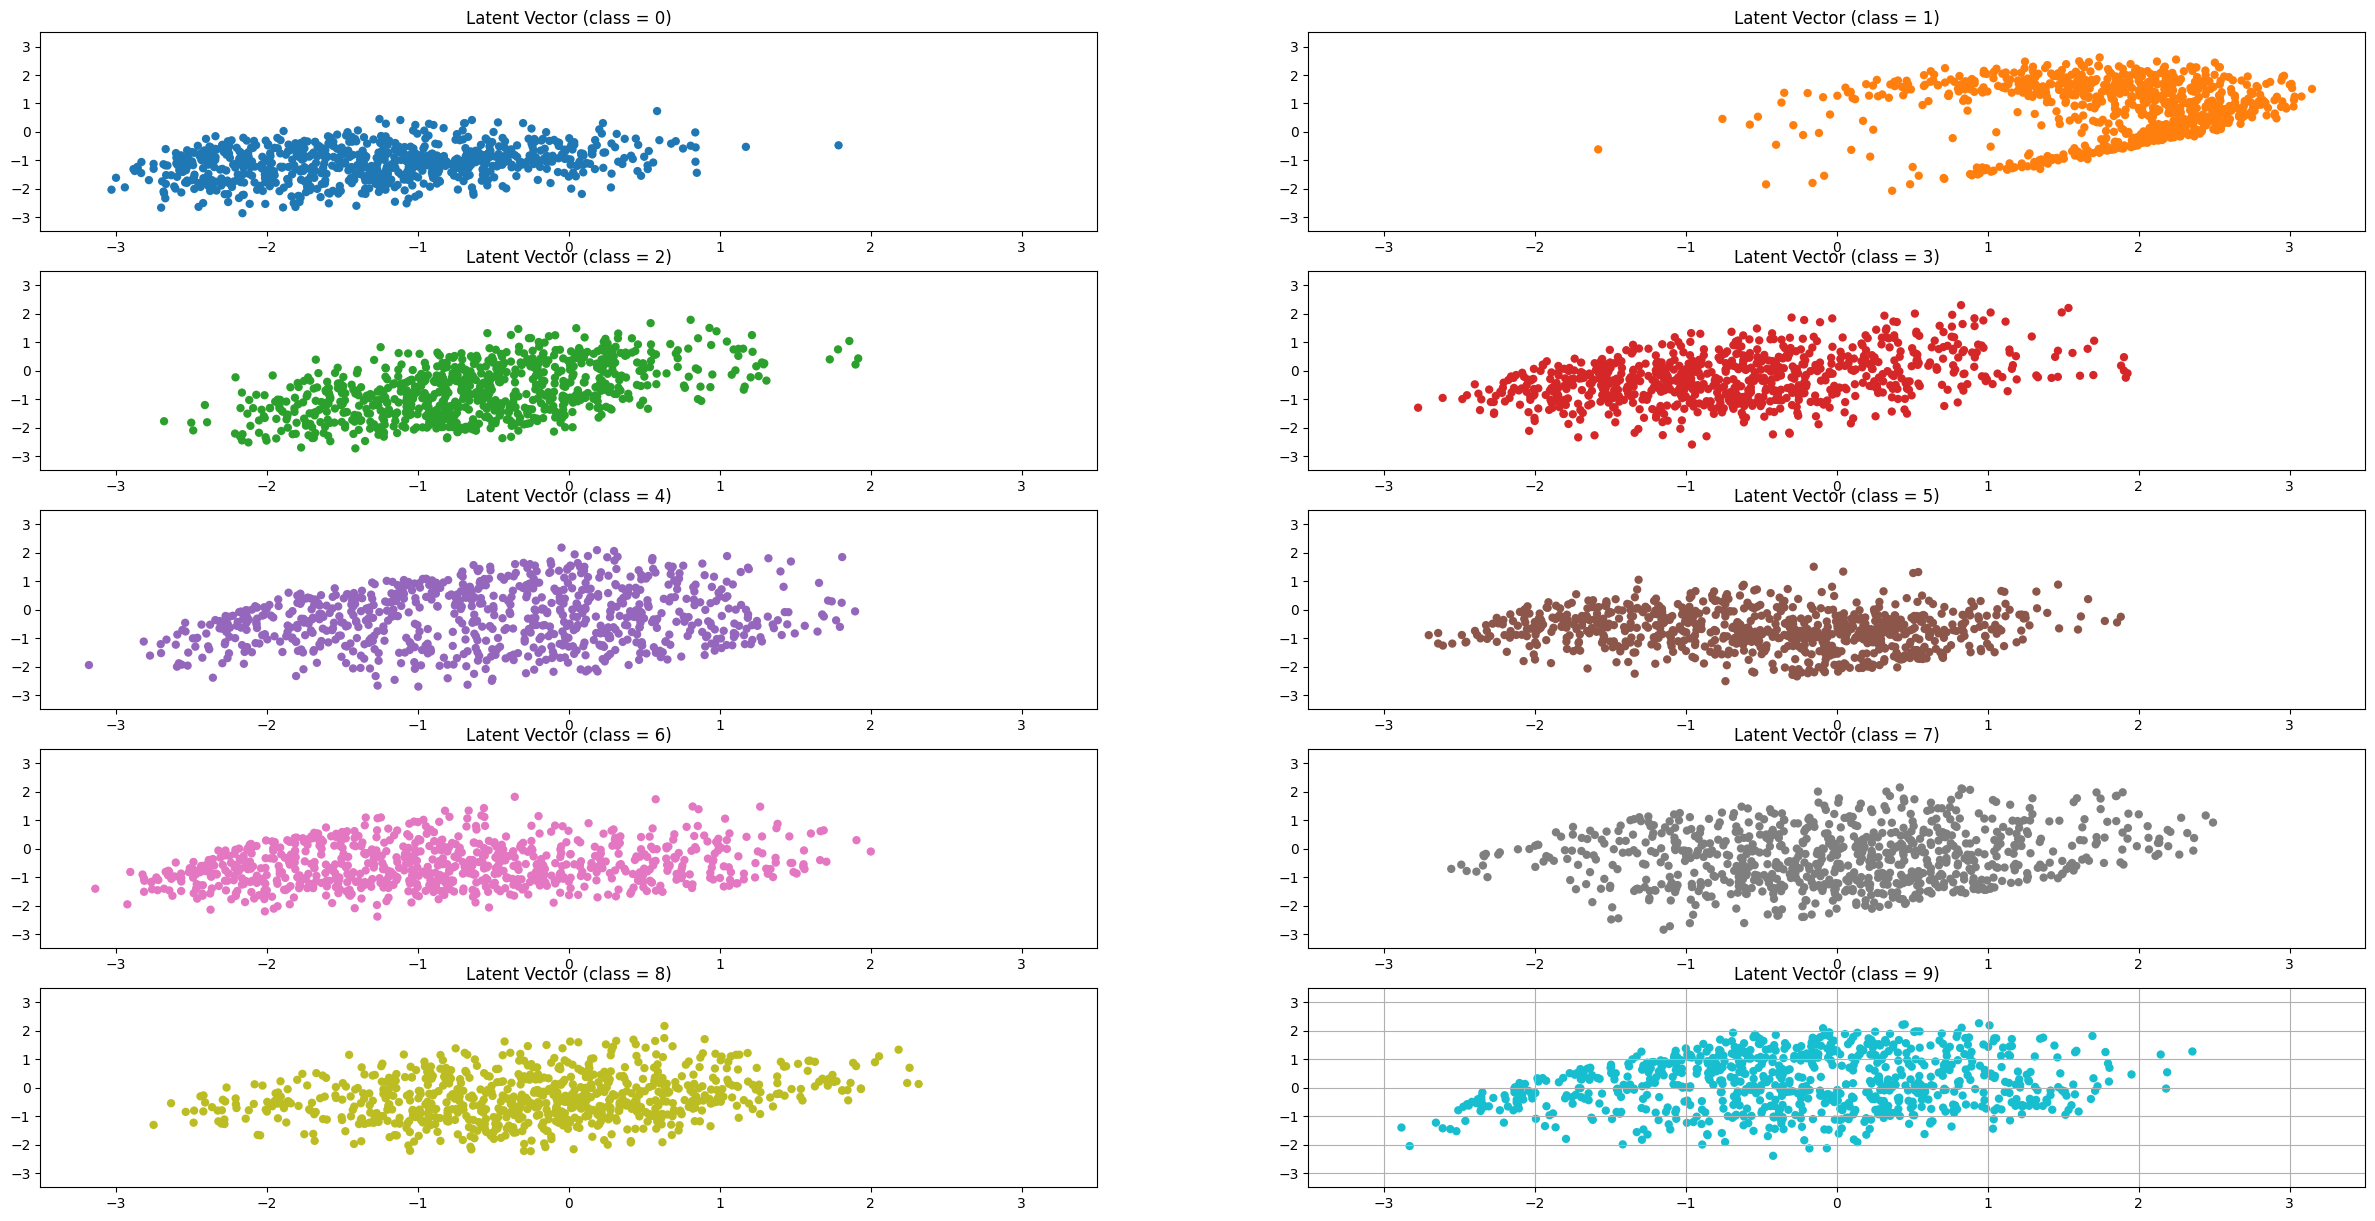

In [92]:
fig, ax = plt.subplots(5,2, figsize=(30, 15))

for class_i, z in enumerate(cvae_z_dict.values()):
  x, y, color = [], [], []
  x = z[:,0]
  y = z[:,1]
  color += [list(color_list.keys())[class_i]]*z.size()[0]

  x, y, color = np.array(x), np.array(y), np.array(color)
  x = x.reshape(-1)
  y = y.reshape(-1)
  color = color.reshape(-1)

  r = class_i//2
  c = class_i%2

  ax[r][c].set_title('Latent Vector (class = {})'.format(class_i))
  ax[r][c].scatter(x, y, c=color, marker='o', edgecolor='none')
  ax[r][c].set_xlim([-3.5, 3.5])
  ax[r][c].set_ylim([-3.5, 3.5])
  plt.grid(True)

  fig.savefig(pwd_folder + 'result/figure_index_0to10.png')

입력 (z, y==class) 중 y를 고정시킨 후 z의 변화에 따른 출력 확인

In [86]:
fixed_y = 9

In [87]:
x = np.arange(-2.5, 2.5 + 0.25, 0.25)
y = np.arange(-2.5, 2.5 + 0.25, 0.25)
test_z = []

for x_ in x:
  for y_ in y:
    test_z.append([x_, y_])

test_z = np.array(test_z)

In [88]:
load_cvae_model.eval()

with torch.no_grad():
  test_z = torch.FloatTensor(test_z)
  fixed_y_one_hot = torch.zeros(test_z.shape[0], 10, dtype=torch.long)
  fixed_y_one_hot[torch.arange(0, 441), fixed_y] = 1

  zy_concat = torch.concatenate((test_z, fixed_y_one_hot), dim=1).to(device)
  reconst_x = load_cvae_model.decoder(zy_concat)
  reconst_img = reconst_x.view(reconst_x.size()[0], 28, 28)
  reconst_img = reconst_img.detach().to('cpu')

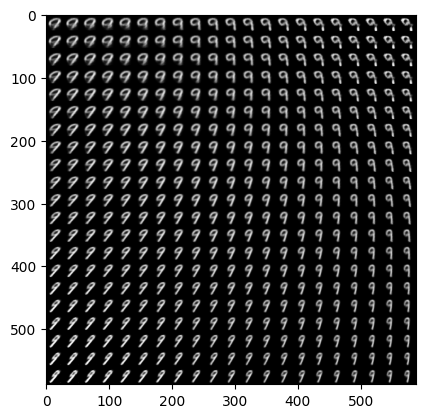

In [89]:
map_img = torch.ones(28*21, 28*21)

i = 0
for r in range(21):
  for c in range(21):
    map_img[r*28:r*28+28, c*28:c*28+28] = reconst_img[i]
    i += 1
save_folder = pwd_folder+'result/'

map_img = np.array(map_img*255).astype(np.uint8)
map_img_bgr = cv2.cvtColor(map_img, cv2.COLOR_GRAY2BGR)
cv2.imwrite(save_folder+'z_map_{}.jpg'.format(fixed_y), map_img_bgr)

plt.imshow(map_img, cmap='gray')